In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as an
import numpy as np
from numpy import random
from qutip import *
import time
import qutip as qt
import os
from datetime import datetime

import scipy as sp
import scipy.optimize
from scipy.optimize import curve_fit

import matplotlib.patches as patches

plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

muB = 5.79e-5 #bohr magnetron in eV
h = 4.15e-15 #plank constant eV.s
hbar = h/(2*np.pi) # reduced Planck constant in eV*s
e = 1.602e-19


In [16]:
# Implement the same time dependent hamiltonian method for a 5x5 hamiltonian

#Define the magnetic fields
    # Magnetic axes x,y and z are chosen based on sample. x-y inplane. z outplane
    # theta is the in-plane angle with theta = 0 along x-axis.
    # phi is the out of plane angle with phi = 90 coresponding the z-axis.

    # We also include independent g-tensor for the left and right dot. 
    # where gxL, gyL and gzL are the observed g-factors of the left dot when B is applied along the x,y,z axis respectively

def Bx(Bmag, theta, phi):
    return Bmag * np.cos(theta) * np.cos(phi)

def By(Bmag, theta, phi):
    return Bmag * np.sin(theta) * np.cos(phi)

def Bz(Bmag, theta, phi):
    return Bmag * np.sin(phi)

def Hz( theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz):
    mu = 5.79e-5
    glyx = glxy
    glzx = glxz
    glzy = glyz
    gryx = grxy
    grzx = grxz
    grzy = gryz
    
    Bxx = Bx(Bmag, theta, phi)
    Byy = By(Bmag, theta, phi)
    Bzz = Bz(Bmag, theta, phi)
    
    result = np.zeros((5, 5), dtype=complex)
    
    result[0, 0] = 1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[0, 1] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) + Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[0, 2] = 0
    result[0, 3] = (((Bxx * (-glxx + 1j * glxy + grxx - 1j * grxy) + Byy * (-glyx + 1j * glyy + gryx - 1j * gryy) + Bzz * (-glzx + 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2)))
    result[0, 4] = 0
    
    result[1, 0] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) + Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 1] = 0
    result[1, 2] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) + Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 3] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[1, 4] = 0
    
    result[2, 0] = 0
    result[2, 1] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) + Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 2] = -1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[2, 3] = ((Bxx * (glxx + 1j * (glxy + 1j * grxx - grxy)) + Byy * (glyx + 1j * glyy - gryx - 1j * gryy) + Bzz * (glzx + 1j * glzy - grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 4] = 0
    
    result[3, 0] = ((Bxx * (-glxx -1j * glxy + grxx + 1j * grxy) + Byy * (-glyx - 1j * glyy + gryx + 1j * gryy) + Bzz * (-glzx - 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 1] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[3, 2] = ((Bxx * (glxx - 1j * glxy - grxx + 1j * grxy) + Byy * (glyx - 1j * glyy - gryx + 1j * gryy) + Bzz * (glzx - 1j * glzy - grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 3] = 0
    result[3, 4] = 0
    
    result[4, 0] = 0
    result[4, 1] = 0
    result[4, 2] = 0
    result[4, 3] = 0
    result[4, 4] = 0
    
    return result

#Define the orbital Hamiltonian
    #tc is the tunnel coupling in eV
    #epsilon is the detuning in eV

def Horb(epsilon, tc):
    return np.array([
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, np.sqrt(2) * tc],
        [0, 0, 0, np.sqrt(2) * tc, epsilon]
    ])

#Define function for Spin orbit Hamiltonian
    #tx,ty,tz are the components of the spin orbit vector projected along the magnetic x,y, and z axes.
def Omega_p(tx, ty):
    return tx + 1j * ty

def Omega_m(tx, ty):
    return tx - 1j * ty

def Omega_pDag(tx, ty):
    return tx - 1j * ty

def Omega_mDag(tx, ty):
    return tx + 1j * ty

def Hso(tx, ty, tz):
    return np.array([
        [0, Omega_p(tx, ty), 0, -Omega_mDag(tx, ty), tz],
        [Omega_pDag(tx, ty), 0, Omega_p(tx, ty), 0, 0],
        [0, Omega_pDag(tx, ty), 0, Omega_m(tx, ty), tz],
        [-Omega_m(tx, ty), 0, Omega_mDag(tx, ty), 0, 0],
        [tz, 0, tz, 0, 0]
    ])

#Construct the full Hamiltonian.
def getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    return Qobj(Hz(theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz) + Horb(epsilon, tc) + Hso(tx, ty, tz))

#extract all eigenenergies as real components, ordered in decending order based on amplitude.
def extract_eigenenergies(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    H = getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
    eigenvalues, _ = np.linalg.eig(H)
    real_eigenvalues = np.real(eigenvalues)  # Extract the real component of eigenvalues
    sorted_eigenvalues = np.sort(real_eigenvalues)[::-1]  # Sort eigenvalues in descending order
    return sorted_eigenvalues

def extract_eigenenergies_and_vectors(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    H = getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
    eigenvalues, eigenvectors = np.linalg.eig(H)
    real_eigenvalues = np.real(eigenvalues)  # Extract the real component of eigenvalues
    sorted_indices = np.argsort(real_eigenvalues)[::-1]  # Sort eigenvalues in descending order and get the corresponding indices

    sorted_eigenvalues = real_eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Convert eigenvectors to Qutip quantum objects
    qutip_eigenvectors = [qt.Qobj(vec) for vec in sorted_eigenvectors.T]

    return sorted_eigenvalues, qutip_eigenvectors

# The same eps_ramp and H_t functions are used from the very first simulation
def eps_ramp(e0, ef, ramp_time, t):
    """Linear detuning ramp function e(t)
    
    Args: 
        e0: initial detuning
        ef: final detuning
        ramp_time: pre-defined ramp time
        t: current time (from t=0 initialisation)
    """

    eps_t = e0 + t*(ef-e0)/ramp_time
    
    return eps_t

def H_t(t,args):
    """Time dependent hamiltonian to be input into qutip.sesolve()
    
    Args:
        t: automatically input by qutip.sesolve() time vector
        args (dictionary): variables used in hamiltonian, set inside qutip.sesovle() argumnents
    """
    # Set variables form args dictionary
    e0 = args['e0']
    ef = args['ef']
    ramp_time = args['ramp_time']
    Bmag = args['B']
    theta = args['theta']
    #tc = args['tc']
    
    # Get e(t) and calculate hamiltonian
    eps_t = eps_ramp(e0,ef,ramp_time, t)
    H = getH(eps_t, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)/hbar
    #print('glxx = ', glxx)
    return H


def extract_freq2(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty):
    tz = 0

    num = len(x)
    for i in range(num):
        epsilon = x[:,0]
        Bmag = x[:,1]
        theta = x[:,2]
        phi = x[:,3]
        levels = extract_eigenenergies(epsilon[i], tc, theta[i], phi[i], Bmag[i], glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
        LZ = levels[3]-levels[4]
        ST = levels[2]-levels[3]
        Total = levels[2]-levels[4]
        freqs = [Total,LZ,ST]
        if i==0:
            fout = freqs
        else:
            fout = np.row_stack((fout,freqs))    
    return fout

# Define the model function to fit
def model_function(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty):
    return extract_freq2(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty).flatten()


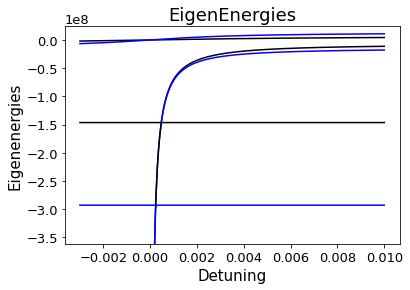

black = 0.01 mT Blue = 0.02 mT:  theta =  90.0 deg: phi =  0.0 deg


In [17]:
#Check the S-To Splitting behaves as expected. 

#plot the eigenenergies for two different field directions,
#Bx => Theta = 0 phi = 0 
#By => Theta = 90 phi = 0 
#Bz => Theta = 0 phi = 90 

# Parameters for the plot

tc = 12e-06
tx = 0
ty = 0
tz = 0.00e+00
glxx = 1.1
glxy = 0
glxz = 0
glyy = 1.1
glyz = 0
glzz = 1.1
grxx = 1
grxy = 0
grxz = 0
gryy = 1
gryz = 0
grzz = 1

# Parameters for the first plot
#Bx => Theta = 0 phi = 0 
#By => Theta = 90 phi = 0 
#Bz => Theta = 0 phi = 90 
theta1 = ((90)*np.pi)/180
phi1 = ((0)*np.pi)/180
Bmag1 = 0.01

#Detuning Range
detuning_range = np.linspace(-3e-3, 10e-3, 500)

eigenenergies = []
eigenenergies2 = []


for detuning in detuning_range:
    eigenvalues = extract_eigenenergies(detuning, tc, theta1, phi1, Bmag1, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, 0)
    eigenvalues2 = extract_eigenenergies(detuning, tc, theta1, phi1, 2*Bmag1, glxx, glxy, glxz,  glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, 0)

    eigenenergies.append(eigenvalues)
    eigenenergies2.append(eigenvalues2)


eigenenergies = np.array(eigenenergies)
eigenenergies2 = np.array(eigenenergies2)


for i in range(eigenenergies.shape[1]):
    plt.plot(detuning_range, eigenenergies[:, i]/h, color='black', label="Level {}".format(i+1))
    plt.plot(detuning_range, eigenenergies2[:, i]/h, color='blue', label="Level {}".format(i+1))
    
plt.xlabel("Detuning")
plt.ylabel("Eigenenergies")
#plt.legend()
plt.ylim(-0.15e-5/h, 0.01e-5/h)
plt.title('EigenEnergies')

plt.show()

print('black =', Bmag1, 'mT','Blue =', 2*Bmag1, 'mT: ', 'theta = ', theta1*180/np.pi, 'deg: phi = ', phi1*180/np.pi, 'deg')




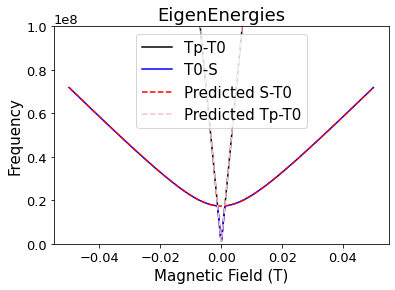

detuning = 0.004 mT: theta =  90.0 deg: phi =  0.0 deg


In [18]:
#Plot the energy splittings as a function of Magnetic field. 
#Also plot the basic calculations of the energy splitting as simple expected from gxx, gyy, gzz

#Detuning
mu = 5.79e-5
eps = 4e-3;
Bmag_range = np.linspace(-0.05, 0.05, 500)
J = np.sqrt((eps**2)/4+2*tc**2)-eps/2

#Calculate the Zeeman energies and Triplet splittings
#if loop depending on the field orientation
#Bx => Theta = 0 phi = 0 
#By => Theta = 90 phi = 0 
#Bz => Theta = 0 phi = 90 
if theta1 == ((0)*np.pi)/180:
    delEz = (glxx-grxx)*mu*Bmag_range ;
    ExpectedTpT0 = np.abs((glxx+grxx)*mu*Bmag_range)/(2*h)
if theta1 == ((90)*np.pi)/180:
    delEz = (glyy-gryy)*mu*Bmag_range ;
    ExpectedTpT0 = np.abs((glyy+gryy)*mu*Bmag_range)/(2*h)
if phi1 == ((90)*np.pi)/180:
    delEz = (glzz-grzz)*mu*Bmag_range ;
    ExpectedTpT0 = np.abs((glzz+grzz)*mu*Bmag_range)/(2*h)

#Used values to calculate predicted S-T0 splitting (eqn1 from paper)
ExpectedST0 = np.sqrt(J**2+delEz**2)/h


Freqs = []

for Bmag in Bmag_range:
    vals = extract_eigenenergies(eps, tc, theta1, phi1, Bmag, glxx, glxy, glxz,  glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, 0)
    splts = -np.diff(vals)/h
    Freqs.append(splts)


Freqs = np.array(Freqs)


plt.plot(Bmag_range, Freqs[:,1], color='black', label="Tp-T0")
plt.plot(Bmag_range, Freqs[:,2], color='blue', label="T0-S")
# plt.plot(Bmag_range, Freqs[:,3], color='green', label="Tm-S")
    
plt.plot(Bmag_range, ExpectedST0, color='red', label="Predicted S-T0", linestyle='--')
plt.plot(Bmag_range, ExpectedTpT0, color='pink', label="Predicted Tp-T0", linestyle='--')
    
plt.xlabel("Magnetic Field (T)")
plt.ylabel("Frequency")
plt.legend()
plt.ylim(0e6, 0.1e9)
plt.title('EigenEnergies')


plt.show()

print('detuning =', eps, 'mT: theta = ', theta1*180/np.pi, 'deg: phi = ', phi1*180/np.pi, 'deg' )

In [254]:
# Reproducing the bug
# Run this code to replace the correct Hz with the old 'bugged' Hz 


def Hz( theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz):
    mu = 5.79e-5
    glyx = glxy
    glzx = glxz
    glzy = glyz
    gryx = grxy
    grzx = grxz
    grzy = gryz
    
    Bxx = Bx(Bmag, theta, phi)
    Byy = By(Bmag, theta, phi)
    Bzz = Bz(Bmag, theta, phi)
    
    result = np.zeros((5, 5), dtype=complex)
    
    result[0, 0] = 1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[0, 1] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) + Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[0, 2] = 0
    result[0, 3] = (((Bxx * (-glxx + 1j * glxy + grxx - 1j * grxy) + Byy * (-glyx + 1j * glyy + gryx - 1j * gryy) + Bzz * (-glzx + 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2)))
    result[0, 4] = 0
    
    result[1, 0] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) + Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 1] = 0
    result[1, 2] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) - Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 3] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[1, 4] = 0
    
    result[2, 0] = 0
    result[2, 1] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) - Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 2] = -1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[2, 3] = ((Bxx * (glxx + 1j * (glxy + 1j * grxx - grxy)) + Byy * (glyx + 1j * glyy - gryx - 1j * gryy) + Bzz * (glzx + 1j * glzy - grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 4] = 0
    
    result[3, 0] = ((Bxx * (-glxx -1j * glxy + grxx + 1j * grxy) + Byy * (-glyx - 1j * glyy + gryx + 1j * gryy) + Bzz * (-glzx - 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 1] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[3, 2] = ((Bxx * (glxx - 1j * glxy - grxx + 1j * grxy) + Byy * (glyx - 1j * glyy - gryx + 1j * gryy) + Bzz * (glzx - 1j * glzy - grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 3] = 0
    result[3, 4] = 0
    
    result[4, 0] = 0
    result[4, 1] = 0
    result[4, 2] = 0
    result[4, 3] = 0
    result[4, 4] = 0
    
    return result

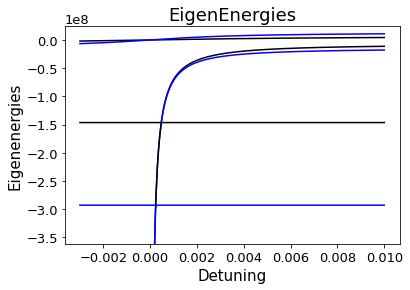

black = 0.01 mT Blue = 0.02 mT:  theta =  90.0 deg: phi =  0.0 deg


In [262]:
#now when you run this there is no effect of By.

#Check the S-To Splitting behaves as expected. 

#plot the eigenenergies for two different field directions,
#Bx => Theta = 0 phi = 0 
#By => Theta = 90 phi = 0 
#Bz => Theta = 0 phi = 90 

# Parameters for the plot

tc = 12e-06
tx = 0
ty = 0
tz = 0.00e+00
glxx = 1.1
glxy = 0
glxz = 0
glyy = 1.1
glyz = 0
glzz = 1.1
grxx = 1
grxy = 0
grxz = 0
gryy = 1
gryz = 0
grzz = 1

# Parameters for the first plot
#Bx => Theta = 0 phi = 0 
#By => Theta = 90 phi = 0 
#Bz => Theta = 0 phi = 90 
theta1 = ((90)*np.pi)/180
phi1 = ((0)*np.pi)/180
Bmag1 = 0.01

#Detuning Range
detuning_range = np.linspace(-3e-3, 10e-3, 500)

eigenenergies = []
eigenenergies2 = []


for detuning in detuning_range:
    eigenvalues = extract_eigenenergies(detuning, tc, theta1, phi1, Bmag1, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, 0)
    eigenvalues2 = extract_eigenenergies(detuning, tc, theta1, phi1, 2*Bmag1, glxx, glxy, glxz,  glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, 0)

    eigenenergies.append(eigenvalues)
    eigenenergies2.append(eigenvalues2)


eigenenergies = np.array(eigenenergies)
eigenenergies2 = np.array(eigenenergies2)


for i in range(eigenenergies.shape[1]):
    plt.plot(detuning_range, eigenenergies[:, i]/h, color='black', label="Level {}".format(i+1))
    plt.plot(detuning_range, eigenenergies2[:, i]/h, color='blue', label="Level {}".format(i+1))
    
plt.xlabel("Detuning")
plt.ylabel("Eigenenergies")
#plt.legend()
plt.ylim(-0.15e-5/h, 0.01e-5/h)
plt.title('EigenEnergies')

plt.show()

print('black =', Bmag1, 'mT','Blue =', 2*Bmag1, 'mT: ', 'theta = ', theta1*180/np.pi, 'deg: phi = ', phi1*180/np.pi, 'deg')
